In [58]:
from matplotlib import pyplot as plt
import os
from os import listdir, getcwd
import numpy as np
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
import json
import time

In [65]:
def snipHorizontal(img):
    crops = []
    height = img.shape[0]
    y = 0

    while(y < height):
        if(not freeHorizontal(img, y)):
            upperSnipY = upperSnip(img, y)
            bottomSnipY = bottomSnip(img, y)
            
            if(upperSnipY == -1 or bottomSnipY == -1):
                #print("Error")
                pass
            else:
                crops.append((upperSnipY, bottomSnipY))
                y = bottomSnipY
            
                
        y += 1

    return crops

def freeHorizontal(img, y):
    width = img.shape[1]

    for x in range(0, width):
        if(img[y][x] <= pivoteColor):
            return False
        
    return True

def upperSnip(img, firstY):

    for y in range(0, firstY):
        y = firstY - y
        if(freeHorizontal(img, y)):
            return y

    return -1#no debería ocurrir

def bottomSnip(img, firstY):
    height = img.shape[0]

    for y in range(firstY, height):
        if(freeHorizontal(img, y)):
            return y

    return -1

def snipVertical(img):
    crops = []
    width = img.shape[1]

    x = 0

    while(x < width):
        if(not freeVertical(img, x)):
            leftSnipX = leftSnip(img, x)
            rightSnipX = rightSnip(img, x)
            
            if(leftSnipX == -1 or rightSnipX == -1):
                print("Error")
            else:
                crops.append((leftSnipX, rightSnipX))
                x = rightSnipX
                
        x += 1
    return crops

def freeVertical(img, x):
    height = img.shape[0]

    for y in range(0, height):
        if(img[y][x] <= pivoteColor):
            return False
        
    return True

def leftSnip(img, firstX):

    for x in range(0, firstX):
        x = firstX - x
        if(freeVertical(img, x)):
            return x

    return -1#no debería ocurrir

def rightSnip(img, firstX):
    width = img.shape[1]

    for x in range(firstX, width):
        if(freeVertical(img, x)):
            return x

    return -1

def cropFila(img, crop):
    width = img.shape[1]
    
    return img[crop[0]: crop[1], 0: width - 1]

def cropColumn(img, crop):
    height = img.shape[0]
    
    return img[0: height - 1, crop[0]: crop[1]]

def cropNumbers(img):
    dataset = []

    crops = snipHorizontal(img)#cortes por fila

    filas = []
    for crop in crops:
        filas.append(cropFila(img, crop))

    for fila in filas:
        crops = snipVertical(fila)#cortes de cada fila por número
        
        for crop in crops:
            numero = cropColumn(fila, crop)
            numero = crop_image(numero)
            dataset.append(numero)#cortes por número
            
    return dataset

def writeDataset(dataset, saveFolder, index = 1):
    i = index
    for image in dataset:
        cv.imwrite(saveFolder + "0" + str(i) + ".jpg", cv.resize(image, resizeDim, interpolation = cv.INTER_AREA))
        i += 1

def plotImage(img):
    plt.figure(figsize=(5, 5))
    plt.subplot(1,1,1)
    plt.imshow(img, cmap = 'gray')
    plt.title('Original')
    plt.show()

def getHorizontalHist(number):
    width = number.shape[1]
    height = number.shape[0]
    
    hist = []
    for y in range(height):
        pixelCount = 0
        for x in range(width):
            if(number[y][x] <= pivoteColor):
                pixelCount += 1
                
        hist.append(pixelCount)

    return hist

def getVerticalHist(number):
    width = number.shape[1]
    height = number.shape[0]
    
    hist = []
    for x in range(width):
        pixelCount = 0
        for y in range(height):    
            if(number[y][x] <= pivoteColor):
                pixelCount += 1
                
        hist.append(pixelCount)

    return hist

#recuperado de
#https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934
def crop_image(img, tol = 80):
    # img is 2D image data
    # tol  is tolerance
    mask = img < tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def getHist4x4(number, pixelWindow):
    width = number.shape[1]
    height = number.shape[0]

    if(width % pixelWindow != 0 or height % pixelWindow != 0):
        newDim = (int(width / pixelWindow) * pixelWindow, int(height / pixelWindow) * pixelWindow)
        number = cv.resize(number, newDim, interpolation = cv.INTER_AREA)

    hist = getHorizontalHist(number) + getVerticalHist(number)
    resumedHist = []

    for i in range(0, len(hist), pixelWindow):
        pixelCount = 0
        for j in range(i, i + pixelWindow):
            pixelCount += hist[j]

        resumedHist.append(pixelCount)
    
    return resumedHist

def readAndCropImage(img, saveFolder):
    ret, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY) #se convierte a una imagen binaria 0 | 255
    plotImage(img)
    dataset = cropNumbers(img)
    writeDataset(dataset, saveFolder)

def getHistsPromAndVariance(hists):

    prom = [0] * len(hists[0])

    for hist in hists:
        prom = np.add(prom, hist)

    prom = np.true_divide(prom, len(hists))

    variance = [0] * len(hists[0])
    for hist in hists:
        variance += np.abs(np.subtract(hist, prom))

    variance = np.true_divide(variance, len(hists))

    return np.around(prom, decimals = 4).tolist(), np.around(variance, decimals = 4).tolist()

def evalNumber(number, prom, variance):
    #pre procesamiento
    if(type(number) != list):
        ret, number = cv.threshold(number, 127, 255, cv.THRESH_BINARY)#se convierte a una imagen binaria 0 | 255
        number = crop_image(number)
        number = cv.resize(number, resizeDim, interpolation = cv.INTER_AREA)

        histNumber = getHist4x4(number, pixelWindowForHist)
    else:
        histNumber = number

    distances = []

    for hist in prom:
        dist = np.linalg.norm(np.array(histNumber) - np.array(hist))
        distances.append(dist)

    i = 0
    while(i < 10):
        predictedNumber = distances.index(min(distances))
        threshold = np.linalg.norm(np.array(variance[predictedNumber]) - np.array(prom[predictedNumber]))

        if(distances[predictedNumber] <= threshold):
            break
        else:
            distances[predictedNumber] = float('inf')

        i += 1

    return predictedNumber, histNumber

def readNumbers(readNumber, readFolder, pixelWindow):
    cwd = os.getcwd()
    pathTrain = cwd + "/" + readFolder
    trainFiles = os.listdir(path=pathTrain)

    hists = []
    y = []

    for imageName in trainFiles:
        number = cv.imread(readFolder + imageName, 0)
        number = cv.resize(number, resizeDim, interpolation = cv.INTER_AREA)
        hists.append((getHist4x4(number, pixelWindow)))
        y.append(readNumber)

    X_train, X_test, y_train, y_test = train_test_split(hists, y, test_size = 0.3, random_state = 42)

    return X_train, [X_test], y_train, [y_test]

def getAccuracys(xTest, yTest, prom, var):

    accuracys = []
    accProm = 0
    for numberValue in range(len(xTest)):
        total = len(xTest[numberValue])
        successCount = 0
        for i in range(total):
            predictedNumber, _ = evalNumber(xTest[numberValue][i], prom, var)
            if(yTest[numberValue][i] == predictedNumber):
                successCount += 1

        accuracys.append("Accuracy para el número " + str(numberValue) + " es de: " + str(round(successCount / total, 4)) + " %")
        accProm += round(successCount / total, 4)

    accuracys.append("Accuracy promedio es de: " + str(round(accProm / len(xTest), 4)) + " %")
    return accuracys

def plotResult(inputImg, predictedNumber, numHist, promHists):

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 6, 1)    
    plt.imshow(inputImg, cmap = 'gray')
    plt.title("Entrada, predicción: " + str(predictedNumber))

    plt.subplot(2, 6, 2)    
    plt.bar([i for i in range(len(numHist))], np.array(numHist))
    plt.title("Histograma de la entrada")

    for i in range(len(promHists)):
        plt.subplot(2, 6, i + 3)
        plt.bar([i for i in range(len(promHists[i]))], np.array(promHists[i]))
        plt.title("Promedio número: " + str(i))

    mng = plt.get_current_fig_manager()
    mng.window.state("zoomed")
    plt.show()

def train_model():

    #saca los promedios de los números
    promHists = []
    varHists = []
    xTest = []
    yTest = []

    for i in range(0, 10):
        X_train, X_test, y_train, y_test = readNumbers(i, str(i) + "/", pixelWindowForHist)
        xTest = xTest + X_test
        yTest = yTest + y_test

        promI, varI = getHistsPromAndVariance(X_train)
        promHists.append(promI)
        varHists.append(varI)

    return promHists, varHists, xTest, yTest

In [10]:
#=============================================================================================================================
#Variables de control
pivoteColor = 200
resizeDim = (50, 150)#imagenes de 50 x 150 para los números individuales

pixelWindowForHist = 8
resizeDim = (int(resizeDim[0] / pixelWindowForHist) * pixelWindowForHist,
            int(resizeDim[1] / pixelWindowForHist) * pixelWindowForHist)
#=============================================================================================================================

In [12]:
Trainlever = False
#=============================================================================================================================
#Entrenamiento
if(Trainlever):

    start = time.perf_counter()

    prom, var, xTest, yTest = train_model()

    tiempo = time.perf_counter() - start

    acurracys = getAccuracys(xTest, yTest, prom, var)

    jsonData = json.dumps({'prom': prom, 'var': var, 'accuracys' : acurracys, 'tiempoEjec': str(tiempo)})

    with open('trained.json', 'w', encoding = 'utf-8') as f:
        json.dump(jsonData, f, ensure_ascii = False, indent = 4)
#=============================================================================================================================
#Accuracy
    
    print("Con una ventana de pixeles de:", pixelWindowForHist)
    for acc in acurracys:
        print(acc)
    print("Tiempo de ejecución:" + str(tiempo))
    

#=============================================================================================================================
else:
    f = open('trained.json')

    data =  json.load(f)
    jsonData = json.loads(data)
    print(len(jsonData['prom']))
    prom = jsonData['prom']
    var = jsonData['var']
    accuracys = jsonData['accuracys']
    tiempo = jsonData['tiempoEjec']

    print("Con una ventana de pixeles de:", pixelWindowForHist)
    for acc in accuracys:
        print(acc)
    print("Tiempo de ejecución:" + str(tiempo))

#Predicciones
#for i in range(10):
#    num = cv.imread(str(i) + ".jpg", 0)
#    predictedNumber, hist = evalNumber(num, prom, var)
#    print("El numero es:", predictedNumber)
#    plotResult(num, predictedNumber, hist, prom)

10
Con una ventana de pixeles de: 8
Accuracy para el número 0 es de: 0.9444 %
Accuracy para el número 1 es de: 1.0 %
Accuracy para el número 2 es de: 0.9167 %
Accuracy para el número 3 es de: 0.6944 %
Accuracy para el número 4 es de: 0.3889 %
Accuracy para el número 5 es de: 0.5 %
Accuracy para el número 6 es de: 0.8889 %
Accuracy para el número 7 es de: 0.5556 %
Accuracy para el número 8 es de: 0.75 %
Accuracy para el número 9 es de: 0.4167 %
Accuracy promedio es de: 0.7056 %
Tiempo de ejecución:45.40846049999993


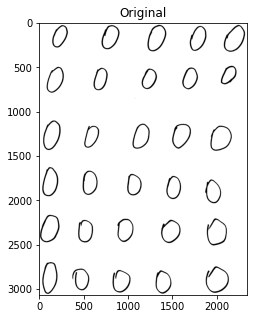

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-zsozjuva\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [66]:
cwd = os.getcwd()
pathTrain = cwd + "/" + "pruebas"
trainFiles = os.listdir(path = pathTrain)

for imageName in trainFiles:
    img = cv.imread("pruebas/" + imageName, 0)
    readAndCropImage(img, "pruebas/")

print("Finished")